# Let's do some Image classification now
### Cause this was the whole point! To see if we can create a ML model to classify clickbait
From the Labelling and Annotation Notebook we have manually generated a small dataset with ~1000 labeled.
Classifying these images was somewhat challenging actually, because of subjectivity. But still,
let's see if our subjective approach produced anything of use

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, Image
import random

random.seed(82)
%matplotlib inline

In [2]:
df = pd.read_pickle("./data/df_partial_labels.pkl")
df.describe()

,video_id,label
count,5962,1179
unique,5962,3
top,czX0j3L2ZzQ,Not_Clickbait
freq,1,666


In [3]:
df.head()

,video_id,label
0,J_CFBjAyPWE,Maybe
1,5qxqo2CQakA,Clickbait
2,4Syrtc5aRBY,Clickbait
3,1mpdJcGj8Qg,Clickbait
4,coOKvrsmQiI,Not_Clickbait


In [4]:
df.tail()

,video_id,label
5957,b191evqWAwE,None
5958,Nk5yOFCsNeE,None
5959,iN8zmmCRqUA,None
5960,ahAnbeyxlic,None
5961,sw7RElt-SvE,None


In [10]:
not_cb = df.loc[df['label'] == 'Not_Clickbait']
cb = df.loc[df['label'] == 'Clickbait']

In [12]:
not_cb.shape, cb.shape

((666, 2), (348, 2))

#### so we have about twice as many not_clickbait as we do clickbait.

In [13]:
not_cb

,video_id,label
4,coOKvrsmQiI,Not_Clickbait
8,AHIrklVaooQ,Not_Clickbait
9,0q9Cm11d-fE,Not_Clickbait
10,ibUV-bxcCZA,Not_Clickbait
11,D_eZxSYRhco,Not_Clickbait
...,...,...
1173,DkeiKbqa02g,Not_Clickbait
1174,xoeObnVyBug,Not_Clickbait
1175,avnapsraeXM,Not_Clickbait
1177,4DQUrg0Yhu4,Not_Clickbait


In [14]:
cb

,video_id,label
1,5qxqo2CQakA,Clickbait
2,4Syrtc5aRBY,Clickbait
3,1mpdJcGj8Qg,Clickbait
5,_Ch5ClOB9AE,Clickbait
7,QDSEpjjavhY,Clickbait
...,...,...
1144,9fed80dZ5wM,Clickbait
1168,pDi7cezk9CA,Clickbait
1170,SPYzQplG_YI,Clickbait
1172,6gFj1XJ6b5o,Clickbait


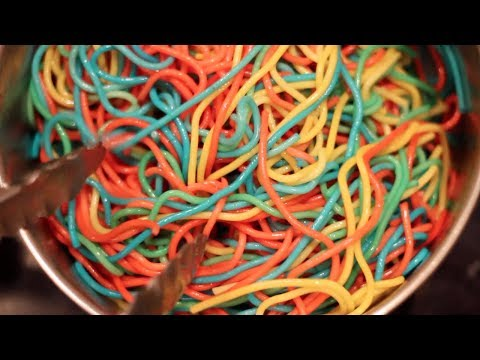

In [19]:
display(Image(f'data/imgs/AHIrklVaooQ.jpg'))

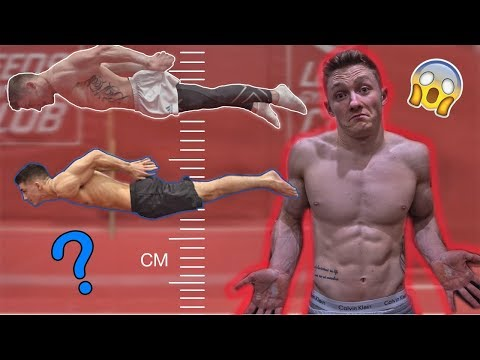

In [22]:
display(Image(f'data/imgs/6gFj1XJ6b5o.jpg'))

In [33]:
labeled_db = df.loc[df['label'].isin(['Not_Clickbait', 'Clickbait'])]

labeled_db = labeled_db.sample(frac=1)  # Shuffle

In [34]:
labeled_db.shape

(1014, 2)

In [82]:
import cv2

def load_and_split(df, SPLIT_COEF=0.8):
    temp = np.array(df)
    train_names = temp[:int(SPLIT_COEF*len(temp))]
    test_names = temp[int(SPLIT_COEF*len(temp)):]

    train_imgs = []
    train_labels = []
    for each in train_names:
        train_imgs.append(cv2.imread(f'data/imgs/{each[0]}.jpg'))
        if each[1] == 'Not_Clickbait':
            train_labels.append(0)
        else:
            train_labels.append(1)
    
    test_imgs = []
    test_labels = []
    for each in test_names:
        test_imgs.append(cv2.imread(f'data/imgs/{each[0]}.jpg'))
        if each[1] == 'Not_Clickbait':
            test_labels.append(0)
        else:
            test_labels.append(1)
    
    train_imgs = np.array(train_imgs)
    train_labels = np.array(train_labels)
    test_imgs = np.array(test_imgs)
    test_labels = np.array(test_labels)
    
    return (train_imgs, train_labels), (test_imgs, test_labels)
    

In [124]:
(train_imgs, train_labels), (test_imgs, test_labels) = load_and_split(labeled_db)

In [84]:
train_imgs.shape

(811, 360, 480, 3)

In [109]:
train_labels.shape

(811, 1)

In [125]:
train_labels = np.expand_dims(train_labels, axis=-1)
test_labels = np.expand_dims(test_labels, axis=-1)

In [86]:
test_imgs.shape

(203, 360, 480, 3)

In [110]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(train_imgs, train_labels, batch_size=32)

In [151]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(test_imgs, test_labels, batch_size=32)

In [170]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(360, 480, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [117]:
from tensorflow import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [171]:
model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=METRICS)

In [172]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 358, 478, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 179, 239, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 177, 237, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 118, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 116, 64)       36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 43, 58, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 41, 56, 64)        3

In [126]:
model.fit(train_generator, epochs=5)

  ...
    to  
  ['...']
Train for 26 steps
Epoch 1/5
 1/26 [>.............................] - ETA: 4:30

KeyboardInterrupt: 

In [127]:
model.evaluate(test_imgs, test_labels)

203/203 [==============================] - 12s 60ms/sample - loss: 0.6549 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 135.0000 - fn: 68.0000 - accuracy: 0.6650 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5369


[0.654882974518931, 0.0, 0.0, 135.0, 68.0, 0.66502464, 0.0, 0.0, 0.53692806]

In [131]:
test_labels.shape

(203, 1)

In [133]:
np.count_nonzero(test_labels == 0)

135

In [137]:
(135)/203  # this is the accuracy produced by the model. Basically always says it's not clickbait. 
# need to introduce weights

0.6650246305418719

# Ignore the top error!
I accidently ran the retraining model, but then interrapted the terminal. 

In [138]:
train_labels.shape

(811, 1)

In [139]:
np.count_nonzero(train_labels == 0)

531

In [146]:
class_weight = {0:(1- 531/811), 1:1-(811-531)/811}

In [152]:
test_labels.shape

(203, 1)

In [173]:
tf.keras.backend.clear_session()

In [174]:
history = model.fit(train_generator, epochs=5, validation_data=test_generator, validation_steps=6, class_weight=class_weight)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 26 steps, validate for 6 steps
Epoch 1/5
26/26 [==============================] - 125s 5s/step - loss: 0.3596 - tp: 155.0000 - fp: 311.0000 - tn: 220.0000 - fn: 125.0000 - accuracy: 0.4624 - precision: 0.3326 - recall: 0.5536 - auc: 0.5031 - val_loss: 0.3103 - val_tp: 61.0000 - val_fp: 94.0000 - val_tn: 33.0000 - val_fn: 4.0000 - val_accuracy: 0.4896 - val_precision: 0.3935 - val_recall: 0.9385 - val_auc: 0.7150
Epoch 2/5
26/26 [==============================] - 114s 4s/step - loss: 0.3095 - tp: 202.0000 - fp: 278.0000 - tn: 253.0000 - fn: 78.0000 - accuracy: 0.5610 - precision: 0.4208 - recall: 0.7214 - auc: 0.6145 - val_loss: 0.3023 - val_tp: 63.0000 - val_fp: 103.0000 - val_tn: 24.0000 - val_fn: 2.0000 - val_accuracy: 0.4531 - val_precision: 0.3795 - val_recall: 0.9692 - val_auc: 0.7209
Epoch 3/5
26/26 [==============================] - 114s 4s/step - loss: 0.2893 - tp: 230.0000 - fp: 295.0000 - tn: 236.0000 - fn: 50.0000 -

In [175]:
hh = history.history

In [176]:
def plot_param(hh, param):
    plt.figure()
    plt.plot(hh[f'{param}'], label='training')
    plt.plot(hh[f'val_{param}'], label='test')
    plt.title(f'{param}')
    plt.legend()
    plt.show()

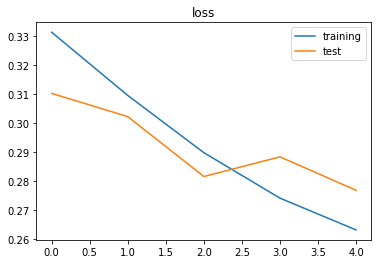

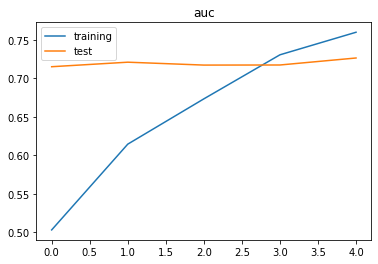

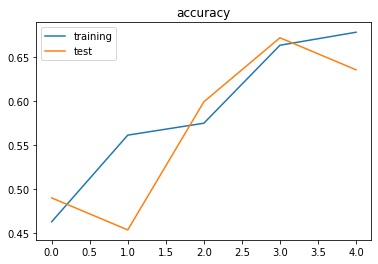

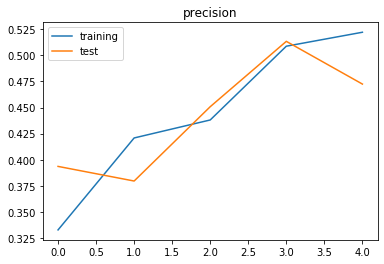

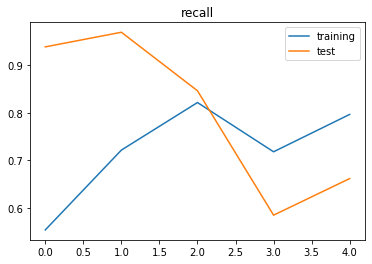

In [178]:
for each in ['loss', 'auc', 'accuracy', 'precision', 'recall']:
    plot_param(hh, each)

# At this point I'll take a break from this experiment as my computer is about to explode
My hardware is not quite suited for ML training, but regradless, here is a quick summary of what happened:
We are dealing with a logistic regression problem. For such problems a good characteristic for model's performace is the ROC curve, and specifically the area under it denoted as AUC. For those unfamiliar, for a balanced dataset we want AUC >> 0.5 (1.0 is max).
Our dataset is imbalanced, so a naive model would produce the AUC equalling to the highest proportion of represented class, in our class not_clickbait is 0.6650 (look below for quick clarification). So basically we are trying to achive AUC > 0.665. Unfortunately, we have outperformed the baseline only slightly with the result of 0.7263, which is not significant enough to claim that we have found a good model!
There could be several problems, for example due to subjectivity of the dataset, or due to it's small size, and also due to the not so big number of epochs. But you know, since 0.7263 is bigger than 0.662 by almost 0.07, I'll call it a victory so that I could sleep a little better at night. Cheers!

In [182]:
test_labels.shape

(203, 1)

In [183]:
np.count_nonzero(test_labels == 0)

135

In [184]:
135/203

0.6650246305418719